In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from reservoirpy.nodes import Reservoir, Ridge, ESN
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd

In [2]:
# Configuration
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
BATCH_SIZE = 64
EMBEDDING_SIZE = 128
NUM_HEADS = 8
NUM_LAYERS = 8
DROPOUT = 0.1
LEARNING_RATE = 1e-4
EPOCHS = 30
PATIENCE = 3

In [18]:
def load_data():
    partOfData = 1
    X_genres = pd.read_csv("../data/train/input_genres_tags_data.csv")
    X_instruments = pd.read_csv("../data/train/input_instruments_tags_data.csv")
    X_moods = pd.read_csv("../data/train/input_moods_tags_data.csv")
    X_genres_categories = pd.read_csv("../data/train/input_genres_categories_data.csv")
    X_instruments_categories = pd.read_csv(
        "../data/train/input_instruments_categories_data.csv"
    )
    X_moods_categories = pd.read_csv("../data/train/input_moods_categories_data.csv")

    y_genres = pd.read_csv("../data/train/output_genres_tags_data.csv")
    y_instruments = pd.read_csv("../data/train/output_instruments_tags_data.csv")
    y_moods = pd.read_csv("../data/train/output_moods_tags_data.csv")

    # On peut garder seulement une partie des données
    X_genres = X_genres[: int(partOfData * len(X_genres))]
    X_instruments = X_instruments[: int(partOfData * len(X_instruments))]
    X_moods = X_moods[: int(partOfData * len(X_moods))]
    y_genres = y_genres[: int(partOfData * len(y_genres))]
    y_instruments = y_instruments[: int(partOfData * len(y_instruments))]
    y_moods = y_moods[: int(partOfData * len(y_moods))]
    X_genres_categories = X_genres_categories[
        : int(partOfData * len(X_genres_categories))
    ]
    X_instruments_categories = X_instruments_categories[
        : int(partOfData * len(X_instruments_categories))
    ]
    X_moods_categories = X_moods_categories[: int(partOfData * len(X_moods_categories))]

    return (
        X_genres,
        X_instruments,
        X_moods,
        X_genres_categories,
        X_instruments_categories,
        X_moods_categories,
    ), (y_genres, y_instruments, y_moods)


# Ensure the input data is in the correct format
def reshape_input(X):
    if isinstance(X, pd.DataFrame):
        return X.values.reshape(-1, 1, X.shape[1])  # Handles pandas DataFrame
    elif isinstance(X, np.ndarray):
        return X.reshape(-1, 1, X.shape[1])  # Handles numpy ndarray
    else:
        raise ValueError("Input must be a pandas DataFrame or a numpy ndarray")


def format_predictions(predictions):
    # Convert the list to a NumPy array
    predictions_array = np.array(predictions)

    # Reshape the array to 2-dimensional
    predictions_reshaped = predictions_array.reshape(-1, predictions_array.shape[-1])

    return predictions_reshaped

In [19]:
# Charger les données
(
    (
        X_genres,
        X_instruments,
        X_moods,
        X_genres_categories,
        X_instruments_categories,
        X_moods_categories,
    ),
    (y_genres, y_instruments, y_moods),
) = load_data()

# Train-test split
X_genres_train, X_genres_test, y_genres_train, y_genres_test = train_test_split(
    X_genres, y_genres, test_size=0.2, random_state=42
)
X_instruments_train, X_instruments_test, y_instruments_train, y_instruments_test = (
    train_test_split(X_instruments, y_instruments, test_size=0.2, random_state=42)
)
X_moods_train, X_moods_test, y_moods_train, y_moods_test = train_test_split(
    X_moods, y_moods, test_size=0.2, random_state=42
)

# Train-test split for categories
X_genres_categories_train, X_genres_categories_test = train_test_split(
    X_genres_categories, test_size=0.2, random_state=42
)
X_instruments_categories_train, X_instruments_categories_test = train_test_split(
    X_instruments_categories, test_size=0.2, random_state=42
)
X_moods_categories_train, X_moods_categories_test = train_test_split(
    X_moods_categories, test_size=0.2, random_state=42
)

In [20]:
# Préparation des données
X_genres_train = X_genres_train.drop(columns=["ChallengeID"])
X_instruments_train = X_instruments_train.drop(columns=["ChallengeID"])
X_moods_train = X_moods_train.drop(columns=["ChallengeID"])
y_genres_train = y_genres_train.drop(columns=["ChallengeID"])
y_instruments_train = y_instruments_train.drop(columns=["ChallengeID"])
y_moods_train = y_moods_train.drop(columns=["ChallengeID"])
X_genres_categories_train = X_genres_categories_train.drop(columns=["ChallengeID"])
X_instruments_categories_train = X_instruments_categories_train.drop(
    columns=["ChallengeID"]
)
X_moods_categories_train = X_moods_categories_train.drop(columns=["ChallengeID"])

X_genres_test = X_genres_test.drop(columns=["ChallengeID"])
X_instruments_test = X_instruments_test.drop(columns=["ChallengeID"])
X_moods_test = X_moods_test.drop(columns=["ChallengeID"])
y_genres_test = y_genres_test.drop(columns=["ChallengeID"])
y_instruments_test = y_instruments_test.drop(columns=["ChallengeID"])
y_moods_test = y_moods_test.drop(columns=["ChallengeID"])
X_genres_categories_test = X_genres_categories_test.drop(columns=["ChallengeID"])
X_instruments_categories_test = X_instruments_categories_test.drop(
    columns=["ChallengeID"]
)
X_moods_categories_test = X_moods_categories_test.drop(columns=["ChallengeID"])


X_train = np.concatenate(
    [
        X_genres_train,
        X_instruments_train,
        X_moods_train,
        X_genres_categories_train,
        X_instruments_categories_train,
        X_moods_categories_train,
    ],
    axis=1,
)
X_test = np.concatenate(
    [
        X_genres_test,
        X_instruments_test,
        X_moods_test,
        X_genres_categories_test,
        X_instruments_categories_test,
        X_moods_categories_test,
    ],
    axis=1,
)

y_train = np.concatenate([y_genres_train, y_instruments_train, y_moods_train], axis=1)
y_test = np.concatenate([y_genres_test, y_instruments_test, y_moods_test], axis=1)

# Convertir les données en tensors PyTorch
X_train_tensor = torch.tensor(X_train, dtype=torch.float32).to(DEVICE)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(DEVICE)

y_train_tensor = torch.tensor(y_train, dtype=torch.float32).to(DEVICE)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).to(DEVICE)

# Générer les données croisées pour les interactions
X_genres_instruments_train = np.concatenate(
    [X_genres_train, X_instruments_train], axis=1
)
X_genres_moods_train = np.concatenate([X_genres_train, X_moods_train], axis=1)
X_instruments_moods_train = np.concatenate([X_instruments_train, X_moods_train], axis=1)
y_genres_instruments_train = np.concatenate(
    [y_genres_train, y_instruments_train], axis=1
)
y_genres_moods_train = np.concatenate([y_genres_train, y_moods_train], axis=1)
y_instruments_moods_train = np.concatenate([y_instruments_train, y_moods_train], axis=1)

X_genres_instruments_test = np.concatenate([X_genres_test, X_instruments_test], axis=1)
X_genres_moods_test = np.concatenate([X_genres_test, X_moods_test], axis=1)
X_instruments_moods_test = np.concatenate([X_instruments_test, X_moods_test], axis=1)
y_genres_instruments_test = np.concatenate([y_genres_test, y_instruments_test], axis=1)
y_genres_moods_test = np.concatenate([y_genres_test, y_moods_test], axis=1)
y_instruments_moods_test = np.concatenate([y_instruments_test, y_moods_test], axis=1)


In [21]:
# Combine all outputs (individual and cross) into a dictionary
X_train_final = {
    "X_genres": X_genres_train,
    "X_instruments": X_instruments_train,
    "X_moods": X_moods_train,
    "X_genres_categories": X_genres_categories_train,
    "X_instruments_categories": X_instruments_categories_train,
    "X_moods_categories": X_moods_categories_train,
}

X_test_final = {
    "X_genres": X_genres_test,
    "X_instruments": X_instruments_test,
    "X_moods": X_moods_test,
    "X_genres_categories": X_genres_categories_test,
    "X_instruments_categories": X_instruments_categories_test,
    "X_moods_categories": X_moods_categories_test,
}

# Define input sizes for the embeddings
input_size_dict = {
    "X_genres": X_genres_train.shape[1],
    "X_instruments": X_instruments_train.shape[1],
    "X_moods": X_moods_train.shape[1],
    "X_genres_categories": X_genres_categories_train.shape[1],
    "X_instruments_categories": X_instruments_categories_train.shape[1],
    "X_moods_categories": X_moods_categories_train.shape[1],
}

# Define the output size
output_size_dict = {
    "y_genres": y_genres_train.shape[1],
    "y_instruments": y_instruments_train.shape[1],
    "y_moods": y_moods_train.shape[1],
}

In [22]:
# Display the shapes of the inputs and outputs
for key, value in input_size_dict.items():
    print(f"{key}: {value}")

for key, value in output_size_dict.items():
    print(f"{key}: {value}")

X_genres: 90
X_instruments: 112
X_moods: 46
X_genres_categories: 18
X_instruments_categories: 15
X_moods_categories: 8
y_genres: 90
y_instruments: 112
y_moods: 46


In [23]:
VALIDATION_SPLIT = 0.2

# Split each array or dataframe individually
X_genres_train_split, X_genres_val_split = train_test_split(
    X_genres_train, test_size=VALIDATION_SPLIT, random_state=42
)
X_instruments_train_split, X_instruments_val_split = train_test_split(
    X_instruments_train, test_size=VALIDATION_SPLIT, random_state=42
)
X_moods_train_split, X_moods_val_split = train_test_split(
    X_moods_train, test_size=VALIDATION_SPLIT, random_state=42
)
y_train_split, y_val_split = train_test_split(
    y_train_tensor.cpu().numpy(), test_size=VALIDATION_SPLIT, random_state=42
)
X_genres_categories_train_split, X_genres_categories_val_split = train_test_split(
    X_genres_categories_train, test_size=VALIDATION_SPLIT, random_state=42
)
X_instruments_categories_train_split, X_instruments_categories_val_split = (
    train_test_split(
        X_instruments_categories_train, test_size=VALIDATION_SPLIT, random_state=42
    )
)
X_moods_categories_train_split, X_moods_categories_val_split = train_test_split(
    X_moods_categories_train, test_size=VALIDATION_SPLIT, random_state=42
)

# Combine back into dictionaries
X_train_final_train = {
    "X_genres": torch.tensor(X_genres_train_split.values, dtype=torch.float32).to(
        DEVICE
    ),
    "X_instruments": torch.tensor(
        X_instruments_train_split.values, dtype=torch.float32
    ).to(DEVICE),
    "X_moods": torch.tensor(X_moods_train_split.values, dtype=torch.float32).to(DEVICE),
    "X_genres_categories": torch.tensor(
        X_genres_categories_train_split.values, dtype=torch.float32
    ).to(DEVICE),
    "X_instruments_categories": torch.tensor(
        X_instruments_categories_train_split.values, dtype=torch.float32
    ).to(DEVICE),
    "X_moods_categories": torch.tensor(
        X_moods_categories_train_split.values, dtype=torch.float32
    ).to(DEVICE),
}
train_targets = torch.tensor(y_train_split, dtype=torch.float32).to(DEVICE)

X_train_final_val = {
    "X_genres": torch.tensor(X_genres_val_split.values, dtype=torch.float32).to(DEVICE),
    "X_instruments": torch.tensor(
        X_instruments_val_split.values, dtype=torch.float32
    ).to(DEVICE),
    "X_moods": torch.tensor(X_moods_val_split.values, dtype=torch.float32).to(DEVICE),
    "X_genres_categories": torch.tensor(
        X_genres_categories_val_split.values, dtype=torch.float32
    ).to(DEVICE),
    "X_instruments_categories": torch.tensor(
        X_instruments_categories_val_split.values, dtype=torch.float32
    ).to(DEVICE),
    "X_moods_categories": torch.tensor(
        X_moods_categories_val_split.values, dtype=torch.float32
    ).to(DEVICE),
}
val_targets = torch.tensor(y_val_split, dtype=torch.float32).to(DEVICE)

# Convert test data to tensors
X_test_final = {
    "X_genres": torch.tensor(X_genres_test.values, dtype=torch.float32).to(DEVICE),
    "X_instruments": torch.tensor(X_instruments_test.values, dtype=torch.float32).to(
        DEVICE
    ),
    "X_moods": torch.tensor(X_moods_test.values, dtype=torch.float32).to(DEVICE),
    "X_genres_categories": torch.tensor(
        X_genres_categories_test.values, dtype=torch.float32
    ).to(DEVICE),
    "X_instruments_categories": torch.tensor(
        X_instruments_categories_test.values, dtype=torch.float32
    ).to(DEVICE),
    "X_moods_categories": torch.tensor(
        X_moods_categories_test.values, dtype=torch.float32
    ).to(DEVICE),
}
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).to(DEVICE)


# Dataset creation function
def create_dataset(X_data, y_data):
    return torch.utils.data.TensorDataset(
        X_data["X_genres"],
        X_data["X_instruments"],
        X_data["X_moods"],
        X_data["X_genres_categories"],
        X_data["X_instruments_categories"],
        X_data["X_moods_categories"],
        y_data,
    )


# Create datasets
train_dataset = create_dataset(X_train_final_train, train_targets)
val_dataset = create_dataset(X_train_final_val, val_targets)
test_dataset = create_dataset(X_test_final, y_test_tensor)

# Create data loaders
train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=BATCH_SIZE, shuffle=True
)
val_loader = torch.utils.data.DataLoader(
    val_dataset, batch_size=BATCH_SIZE, shuffle=False
)
test_loader = torch.utils.data.DataLoader(
    test_dataset, batch_size=BATCH_SIZE, shuffle=False
)

# Check loaders
# for batch in train_loader:
#     print("Train batch sample:", batch)
#     break

# for batch in val_loader:
#     print("Validation batch sample:", batch)
#     break

# for batch in test_loader:
#     print("Test batch sample:", batch)
#     break

In [24]:
train_dataset.tensors[0].shape, train_dataset.tensors[1].shape

(torch.Size([70946, 90]), torch.Size([70946, 112]))

In [10]:
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score
from tqdm import tqdm


# Concaténer toutes les caractéristiques d'entrée et les prédictions des réservoirs de neurones
def prepare_data_for_rf(X_train_final, y_train):
    X_train_concat = np.concatenate(
        [
            X_train_final["X_genres"].cpu().numpy(),
            X_train_final["X_instruments"].cpu().numpy(),
            X_train_final["X_moods"].cpu().numpy(),
            X_train_final["X_genres_categories"].cpu().numpy(),
            X_train_final["X_instruments_categories"].cpu().numpy(),
            X_train_final["X_moods_categories"].cpu().numpy(),
        ],
        axis=1,
    )
    return X_train_concat, y_train


# Préparer les données pour le Random Forest
X_train_rf, y_train_rf = prepare_data_for_rf(
    X_train_final_train, train_targets.cpu().numpy()
)
X_val_rf, y_val_rf = prepare_data_for_rf(X_train_final_val, val_targets.cpu().numpy())
X_test_rf, y_test_rf = prepare_data_for_rf(X_test_final, y_test_tensor.cpu().numpy())

# Initialiser le Random Forest Classifier
rf_model = RandomForestClassifier(n_estimators=10, random_state=42, warm_start=True)

# Entraîner le modèle avec une barre de progression
for i in tqdm(range(rf_model.n_estimators), desc="Training Random Forest"):
    rf_model.n_estimators = i + 1
    rf_model.fit(X_train_rf, y_train_rf)

# Évaluer le modèle sur l'ensemble de validation
y_val_pred_rf = rf_model.predict(X_val_rf)
val_accuracy = accuracy_score(y_val_rf, y_val_pred_rf)
val_f1 = f1_score(y_val_rf, y_val_pred_rf, average="weighted")
print(f"Validation Accuracy: {val_accuracy:.4f}, Validation F1 Score: {val_f1:.4f}")

# Évaluer le modèle sur l'ensemble de test
y_test_pred_rf = rf_model.predict(X_test_rf)
test_accuracy = accuracy_score(y_test_rf, y_test_pred_rf)
test_f1 = f1_score(y_test_rf, y_test_pred_rf, average="weighted")
print(f"Test Accuracy: {test_accuracy:.4f}, Test F1 Score: {test_f1:.4f}")


Training Random Forest: 100%|██████████| 10/10 [02:19<00:00, 13.93s/it]


Validation Accuracy: 0.0057, Validation F1 Score: 0.3151
Test Accuracy: 0.0054, Test F1 Score: 0.3131


In [16]:
from sklearn.decomposition import PCA

# Réduire la dimensionnalité des données avec PCA
pca = PCA(n_components=100)  # Ajustez le nombre de composants selon vos besoins
X_train_pca = pca.fit_transform(X_train_rf)
X_val_pca = pca.transform(X_val_rf)
X_test_pca = pca.transform(X_test_rf)

# # Initialiser le Random Forest Classifier
# rf_model2 = RandomForestClassifier(n_estimators=100, random_state=42, warm_start=True)

# # Entraîner le modèle avec une barre de progression
# for i in tqdm(range(rf_model.n_estimators), desc="Training Random Forest"):
#     rf_model.n_estimators = i + 1
#     rf_model.fit(X_train_pca, y_train_rf)

# # Évaluer le modèle sur l'ensemble de validation
# y_val_pred_rf = rf_model.predict(X_val_pca)
# val_accuracy = accuracy_score(y_val_rf, y_val_pred_rf)
# val_f1 = f1_score(y_val_rf, y_val_pred_rf, average='weighted')
# print(f"Validation Accuracy: {val_accuracy:.4f}, Validation F1 Score: {val_f1:.4f}")

# # Évaluer le modèle sur l'ensemble de test
# y_test_pred_rf = rf_model.predict(X_test_pca)
# test_accuracy = accuracy_score(y_test_rf, y_test_pred_rf)
# test_f1 = f1_score(y_test_rf, y_test_pred_rf, average='weighted')
# print(f"Test Accuracy: {test_accuracy:.4f}, Test F1 Score: {test_f1:.4f}")


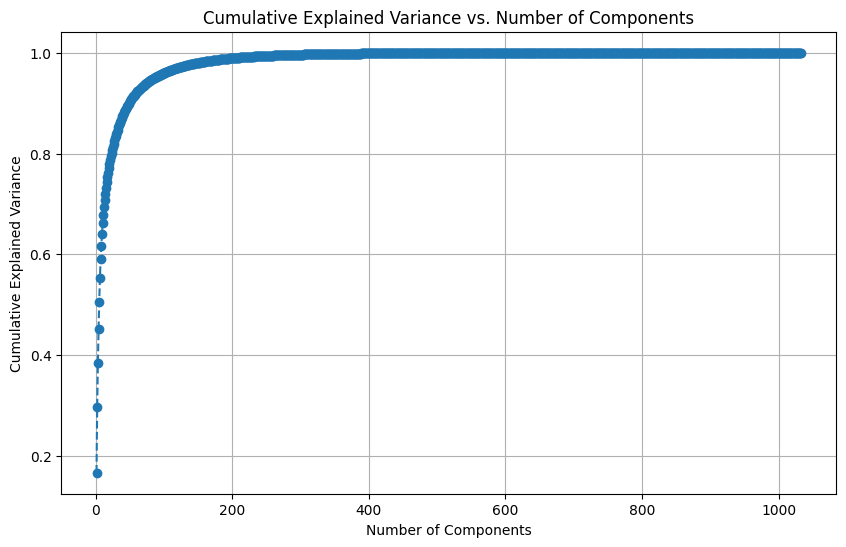

Number of components to explain 95% of variance: 86


In [16]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Initialiser PCA
pca = PCA()

# Ajuster PCA sur les données d'entraînement
pca.fit(X_train_rf)

# Calculer la variance expliquée cumulée
explained_variance = np.cumsum(pca.explained_variance_ratio_)

# Tracer la variance expliquée cumulée
plt.figure(figsize=(10, 6))
plt.plot(
    range(1, len(explained_variance) + 1),
    explained_variance,
    marker="o",
    linestyle="--",
)
plt.xlabel("Number of Components")
plt.ylabel("Cumulative Explained Variance")
plt.title("Cumulative Explained Variance vs. Number of Components")
plt.grid()
plt.show()

# Choisir le nombre de composants pour expliquer 95% de la variance
n_components = np.argmax(explained_variance >= 0.95) + 1
print(f"Number of components to explain 95% of variance: {n_components}")


In [13]:
from sklearn.preprocessing import StandardScaler

# Concaténer toutes les caractéristiques d'entrée et les prédictions des réservoirs de neurones
def prepare_data_for_rf(X_train_final, y_train):
    X_train_concat = np.concatenate(
        [
            X_train_final["X_genres"].cpu().numpy(),
            X_train_final["X_instruments"].cpu().numpy(),
            X_train_final["X_moods"].cpu().numpy(),
            X_train_final["X_genres_categories"].cpu().numpy(),
            X_train_final["X_instruments_categories"].cpu().numpy(),
            X_train_final["X_moods_categories"].cpu().numpy(),
        ],
        axis=1,
    )
    # Normaliser les données
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train_concat)
    
    return X_train_scaled, y_train

In [14]:
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score
from tqdm import tqdm
from sklearn.decomposition import PCA




# Préparer les données pour le Random Forest
X_train_rf, y_train_rf = prepare_data_for_rf(
    X_train_final_train, train_targets.cpu().numpy()
)
X_val_rf, y_val_rf = prepare_data_for_rf(X_train_final_val, val_targets.cpu().numpy())
X_test_rf, y_test_rf = prepare_data_for_rf(X_test_final, y_test_tensor.cpu().numpy())

# Réduire la dimensionnalité des données avec PCA
pca = PCA(n_components=100)  # Ajustez le nombre de composants selon vos besoins
X_train_pca = pca.fit_transform(X_train_rf)
X_val_pca = pca.transform(X_val_rf)
X_test_pca = pca.transform(X_test_rf)

# Initialiser le Random Forest Classifier
rf_model = RandomForestClassifier(n_estimators=50, random_state=42, warm_start=True)

# Entraîner le modèle avec une barre de progression
for i in tqdm(range(rf_model.n_estimators), desc="Training Random Forest"):
    rf_model.n_estimators = i + 1
    rf_model.fit(X_train_pca, y_train_rf)

# Évaluer le modèle sur l'ensemble de validation
y_val_pred_rf = rf_model.predict(X_val_pca)
val_accuracy = accuracy_score(y_val_rf, y_val_pred_rf)
val_f1 = f1_score(y_val_rf, y_val_pred_rf, average='weighted')
print(f"Validation Accuracy: {val_accuracy:.4f}, Validation F1 Score: {val_f1:.4f}")

# Évaluer le modèle sur l'ensemble de test
y_test_pred_rf = rf_model.predict(X_test_pca)
test_accuracy = accuracy_score(y_test_rf, y_test_pred_rf)
test_f1 = f1_score(y_test_rf, y_test_pred_rf, average='weighted')
print(f"Test Accuracy: {test_accuracy:.4f}, Test F1 Score: {test_f1:.4f}")


Training Random Forest:   2%|▏         | 1/50 [00:18<15:09, 18.56s/it]


KeyboardInterrupt: 

In [15]:
# Évaluer le modèle sur l'ensemble de validation
y_val_pred_rf = rf_model.predict(X_val_pca)
val_accuracy = accuracy_score(y_val_rf, y_val_pred_rf)
val_f1 = f1_score(y_val_rf, y_val_pred_rf, average='weighted')
print(f"Validation Accuracy: {val_accuracy:.4f}, Validation F1 Score: {val_f1:.4f}")

# Évaluer le modèle sur l'ensemble de test
y_test_pred_rf = rf_model.predict(X_test_pca)
test_accuracy = accuracy_score(y_test_rf, y_test_pred_rf)
test_f1 = f1_score(y_test_rf, y_test_pred_rf, average='weighted')
print(f"Test Accuracy: {test_accuracy:.4f}, Test F1 Score: {test_f1:.4f}")

Validation Accuracy: 0.0074, Validation F1 Score: 0.3271
Test Accuracy: 0.0074, Test F1 Score: 0.3272


In [16]:
import numpy as np
from sklearn.decomposition import PCA

# Supposons que X_train_rf soit votre matrice de données d'origine
# X_train_rf est un tableau NumPy ou une structure similaire

# Initialiser PCA
pca = PCA()

# Ajuster PCA sur les données d'entraînement
pca.fit(X_train_rf)

# Obtenir le nombre de composants principaux
n_components_total = pca.n_components_

print(f"Nombre total de composants principaux initialement: {n_components_total}")


Nombre total de composants principaux initialement: 289


In [17]:
import lightgbm as lgb
from sklearn.metrics import accuracy_score, f1_score
import numpy as np

# Préparer les données pour LightGBM
X_train_lgb, y_train_lgb = prepare_data_for_rf(X_train_final_train, train_targets.cpu().numpy())
X_val_lgb, y_val_lgb = prepare_data_for_rf(X_train_final_val, val_targets.cpu().numpy())
X_test_lgb, y_test_lgb = prepare_data_for_rf(X_test_final, y_test_tensor.cpu().numpy())

# Initialiser les modèles LightGBM pour chaque label
num_labels = y_train_lgb.shape[1]
lgb_models = [lgb.LGBMClassifier(objective='binary', n_estimators=100, random_state=42, device='gpu') for _ in range(num_labels)]

# Entraîner les modèles
for i in range(num_labels):
    lgb_models[i].fit(X_train_lgb, y_train_lgb[:, i])

# Évaluer les modèles sur l'ensemble de validation
y_val_pred_lgb = np.zeros_like(y_val_lgb)
for i in range(num_labels):
    y_val_pred_lgb[:, i] = lgb_models[i].predict(X_val_lgb)
y_val_pred_lgb = (y_val_pred_lgb > 0.5).astype(int)
val_accuracy = accuracy_score(y_val_lgb, y_val_pred_lgb)
val_f1 = f1_score(y_val_lgb, y_val_pred_lgb, average='weighted')
print(f"Validation Accuracy: {val_accuracy:.4f}, Validation F1 Score: {val_f1:.4f}")

# Évaluer les modèles sur l'ensemble de test
y_test_pred_lgb = np.zeros_like(y_test_lgb)
for i in range(num_labels):
    y_test_pred_lgb[:, i] = lgb_models[i].predict(X_test_lgb)
y_test_pred_lgb = (y_test_pred_lgb > 0.5).astype(int)
test_accuracy = accuracy_score(y_test_lgb, y_test_pred_lgb)
test_f1 = f1_score(y_test_lgb, y_test_pred_lgb, average='weighted')
print(f"Test Accuracy: {test_accuracy:.4f}, Test F1 Score: {test_f1:.4f}")


[LightGBM] [Info] Number of positive: 569, number of negative: 70377
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 73695
[LightGBM] [Info] Number of data points in the train set: 70946, number of used features: 289
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 3060, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 289 dense feature groups (19.76 MB) transferred to GPU in 0.007766 secs. 0 sparse feature groups
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008020 -> initscore=-4.817741
[LightGBM] [Info] Start training from score -4.817741
[LightGBM] [Info] Number of positive: 3983, number of negative: 66963
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 73695
[LightGBM] [Info] Number of data points in the train set: 70946, number of used features: 289
[LightGBM] [Info] Using

In [22]:
import lightgbm as lgb
import numpy as np
from sklearn.metrics import accuracy_score, f1_score

# Préparer les données pour LightGBM
X_train_lgb, y_train_lgb = prepare_data_for_rf(X_train_final_train, train_targets.cpu().numpy())
X_val_lgb, y_val_lgb = prepare_data_for_rf(X_train_final_val, val_targets.cpu().numpy())
X_test_lgb, y_test_lgb = prepare_data_for_rf(X_test_final, y_test_tensor.cpu().numpy())

# Initialiser les modèles LightGBM pour chaque label
num_labels = y_train_lgb.shape[1]
lgb_models = [lgb.LGBMClassifier(objective='binary', n_estimators=100, random_state=42, device='gpu') for _ in range(num_labels)]

# Calculer les poids de classe
class_weights = np.sum(y_train_lgb, axis=0) / y_train_lgb.shape[0]
class_weights = 1 / class_weights
class_weights = class_weights / np.sum(class_weights)

# Entraîner les modèles
for i in range(num_labels):
    sample_weight = np.where(y_train_lgb[:, i] == 1, class_weights[i], 1 - class_weights[i])
    lgb_models[i].fit(X_train_lgb, y_train_lgb[:, i], sample_weight=sample_weight)

# Évaluer les modèles sur l'ensemble de validation
y_val_pred_lgb = np.zeros_like(y_val_lgb)
for i in range(num_labels):
    y_val_pred_lgb[:, i] = lgb_models[i].predict(X_val_lgb)
y_val_pred_lgb = (y_val_pred_lgb > 0.5).astype(int)
val_accuracy = accuracy_score(y_val_lgb, y_val_pred_lgb)
val_f1 = f1_score(y_val_lgb, y_val_pred_lgb, average='weighted')
print(f"Validation Accuracy: {val_accuracy:.4f}, Validation F1 Score: {val_f1:.4f}")

# Évaluer les modèles sur l'ensemble de test
y_test_pred_lgb = np.zeros_like(y_test_lgb)
for i in range(num_labels):
    y_test_pred_lgb[:, i] = lgb_models[i].predict(X_test_lgb)
y_test_pred_lgb = (y_test_pred_lgb > 0.5).astype(int)
test_accuracy = accuracy_score(y_test_lgb, y_test_pred_lgb)
test_f1 = f1_score(y_test_lgb, y_test_pred_lgb, average='weighted')
print(f"Test Accuracy: {test_accuracy:.4f}, Test F1 Score: {test_f1:.4f}")


[LightGBM] [Info] Number of positive: 569, number of negative: 70377
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 263415
[LightGBM] [Info] Number of data points in the train set: 70946, number of used features: 1033
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 3060, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 1033 dense feature groups (70.10 MB) transferred to GPU in 0.014323 secs. 0 sparse feature groups
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000032 -> initscore=-10.360829
[LightGBM] [Info] Start training from score -10.360829
[LightGBM] [Info] Number of positive: 3983, number of negative: 66963
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 263415
[LightGBM] [Info] Number of data points in the train set: 70946, number of used features: 1033
[LightGBM] [Info

In [ ]:
from imblearn.over_sampling import RandomOverSampler
from sklearn.preprocessing import StandardScaler, LabelBinarizer
import lightgbm as lgb
from sklearn.metrics import accuracy_score, f1_score
import numpy as np

def prepare_data_for_rf(X_train_final, y_train):
    X_train_concat = np.concatenate(
        [
            X_train_final["X_genres"].cpu().numpy(),
            X_train_final["X_instruments"].cpu().numpy(),
            X_train_final["X_moods"].cpu().numpy(),
            X_train_final["X_genres_categories"].cpu().numpy(),
            X_train_final["X_instruments_categories"].cpu().numpy(),
            X_train_final["X_moods_categories"].cpu().numpy(),
        ],
        axis=1,
    )

    # Normaliser les données
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train_concat)

    # Convertir y_train en format binaire
    lb = LabelBinarizer()
    y_train_bin = lb.fit_transform(y_train)

    # Appliquer le rééchantillonnage pour chaque label binaire
    ros = RandomOverSampler(random_state=42)
    X_train_resampled_list = []
    y_train_resampled_list = []

    for i in range(y_train_bin.shape[1]):
        X_resampled, y_resampled = ros.fit_resample(X_train_scaled, y_train_bin[:, i])
        X_train_resampled_list.append(X_resampled)
        y_train_resampled_list.append(y_resampled.reshape(-1, 1))

    # Concaténer les données rééchantillonnées
    X_train_resampled = np.concatenate(X_train_resampled_list, axis=0)
    y_train_resampled = np.concatenate(y_train_resampled_list, axis=0)

    return X_train_resampled, y_train_resampled

# Préparer les données pour LightGBM
X_train_lgb, y_train_lgb = prepare_data_for_rf(X_train_final_train, train_targets.cpu().numpy())
X_val_lgb, y_val_lgb = prepare_data_for_rf(X_train_final_val, val_targets.cpu().numpy())
X_test_lgb, y_test_lgb = prepare_data_for_rf(X_test_final, y_test_tensor.cpu().numpy())

# Initialiser les modèles LightGBM pour chaque label
num_labels = y_train_lgb.shape[1]
lgb_models = [lgb.LGBMClassifier(objective='binary', n_estimators=100, random_state=42) for _ in range(num_labels)]

# Entraîner les modèles
for i in range(num_labels):
    lgb_models[i].fit(X_train_lgb, y_train_lgb[:, i])

# Évaluer les modèles sur l'ensemble de validation
y_val_pred_lgb = np.zeros_like(y_val_lgb)
for i in range(num_labels):
    y_val_pred_lgb[:, i] = lgb_models[i].predict(X_val_lgb)
y_val_pred_lgb = (y_val_pred_lgb > 0.5).astype(int)
val_accuracy = accuracy_score(y_val_lgb, y_val_pred_lgb)
val_f1 = f1_score(y_val_lgb, y_val_pred_lgb, average='weighted')
print(f"Validation Accuracy: {val_accuracy:.4f}, Validation F1 Score: {val_f1:.4f}")

# Évaluer les modèles sur l'ensemble de test
y_test_pred_lgb = np.zeros_like(y_test_lgb)
for i in range(num_labels):
    y_test_pred_lgb[:, i] = lgb_models[i].predict(X_test_lgb)
y_test_pred_lgb = (y_test_pred_lgb > 0.5).astype(int)
test_accuracy = accuracy_score(y_test_lgb, y_test_pred_lgb)
test_f1 = f1_score(y_test_lgb, y_test_pred_lgb, average='weighted')
print(f"Test Accuracy: {test_accuracy:.4f}, Test F1 Score: {test_f1:.4f}")


In [14]:
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler, LabelBinarizer
import lightgbm as lgb
from sklearn.metrics import accuracy_score, f1_score
import numpy as np

def prepare_data_for_rf(X_train_final, y_train):
    X_train_concat = np.concatenate(
        [
            X_train_final["X_genres"].cpu().numpy(),
            X_train_final["X_instruments"].cpu().numpy(),
            X_train_final["X_moods"].cpu().numpy(),
            X_train_final["X_genres_categories"].cpu().numpy(),
            X_train_final["X_instruments_categories"].cpu().numpy(),
            X_train_final["X_moods_categories"].cpu().numpy(),
        ],
        axis=1,
    )

    # Normaliser les données
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train_concat)

    # Convertir y_train en format binaire
    lb = LabelBinarizer()
    y_train_bin = lb.fit_transform(y_train)

    # Appliquer le rééchantillonnage pour chaque label binaire
    smote = SMOTE(random_state=42)
    X_train_resampled_list = []
    y_train_resampled_list = []

    for i in range(y_train_bin.shape[1]):
        X_resampled, y_resampled = smote.fit_resample(X_train_scaled, y_train_bin[:, i])
        X_train_resampled_list.append(X_resampled)
        y_train_resampled_list.append(y_resampled.reshape(-1, 1))

    # Concaténer les données rééchantillonnées
    X_train_resampled = np.concatenate(X_train_resampled_list, axis=0)
    y_train_resampled = np.concatenate(y_train_resampled_list, axis=0)

    return X_train_resampled, y_train_resampled

# Préparer les données pour LightGBM
X_train_lgb, y_train_lgb = prepare_data_for_rf(X_train_final_train, train_targets.cpu().numpy())
X_val_lgb, y_val_lgb = prepare_data_for_rf(X_train_final_val, val_targets.cpu().numpy())
X_test_lgb, y_test_lgb = prepare_data_for_rf(X_test_final, y_test_tensor.cpu().numpy())

# Initialiser les modèles LightGBM pour chaque label
num_labels = y_train_lgb.shape[1]
lgb_models = [lgb.LGBMClassifier(objective='binary', n_estimators=100, random_state=42) for _ in range(num_labels)]

# Entraîner les modèles par mini-batchs
batch_size = 1000
for i in range(num_labels):
    for start in range(0, len(X_train_lgb), batch_size):
        end = start + batch_size
        lgb_models[i].fit(X_train_lgb[start:end], y_train_lgb[start:end, i], init_score=lgb_models[i].best_score_)

# Évaluer les modèles sur l'ensemble de validation
y_val_pred_lgb = np.zeros_like(y_val_lgb)
for i in range(num_labels):
    y_val_pred_lgb[:, i] = lgb_models[i].predict(X_val_lgb)
y_val_pred_lgb = (y_val_pred_lgb > 0.5).astype(int)
val_accuracy = accuracy_score(y_val_lgb, y_val_pred_lgb)
val_f1 = f1_score(y_val_lgb, y_val_pred_lgb, average='weighted')
print(f"Validation Accuracy: {val_accuracy:.4f}, Validation F1 Score: {val_f1:.4f}")

# Évaluer les modèles sur l'ensemble de test
y_test_pred_lgb = np.zeros_like(y_test_lgb)
for i in range(num_labels):
    y_test_pred_lgb[:, i] = lgb_models[i].predict(X_test_lgb)
y_test_pred_lgb = (y_test_pred_lgb > 0.5).astype(int)
test_accuracy = accuracy_score(y_test_lgb, y_test_pred_lgb)
test_f1 = f1_score(y_test_lgb, y_test_pred_lgb, average='weighted')
print(f"Test Accuracy: {test_accuracy:.4f}, Test F1 Score: {test_f1:.4f}")


KeyboardInterrupt: 

In [34]:
import xgboost as xgb
from sklearn.metrics import accuracy_score, f1_score
import numpy as np

# Préparer les données pour XGBoost
X_train_xgb, y_train_xgb = prepare_data_for_rf(X_train_final_train, train_targets.cpu().numpy())
X_val_xgb, y_val_xgb = prepare_data_for_rf(X_train_final_val, val_targets.cpu().numpy())
X_test_xgb, y_test_xgb = prepare_data_for_rf(X_test_final, y_test_tensor.cpu().numpy())

# Initialiser les modèles XGBoost pour chaque label
num_labels = y_train_xgb.shape[1]
xgb_models = [xgb.XGBClassifier(objective='binary:logistic', n_estimators=100, random_state=42) for _ in range(num_labels)]

# Entraîner les modèles
for i in range(num_labels):
    xgb_models[i].fit(X_train_xgb, y_train_xgb[:, i])

# Évaluer les modèles sur l'ensemble de validation
y_val_pred_xgb = np.zeros_like(y_val_xgb)
for i in range(num_labels):
    y_val_pred_xgb[:, i] = xgb_models[i].predict(X_val_xgb)
y_val_pred_xgb = (y_val_pred_xgb > 0.5).astype(int)
val_accuracy = accuracy_score(y_val_xgb, y_val_pred_xgb)
val_f1 = f1_score(y_val_xgb, y_val_pred_xgb, average='weighted')
print(f"Validation Accuracy: {val_accuracy:.4f}, Validation F1 Score: {val_f1:.4f}")

# Évaluer les modèles sur l'ensemble de test
y_test_pred_xgb = np.zeros_like(y_test_xgb)
for i in range(num_labels):
    y_test_pred_xgb[:, i] = xgb_models[i].predict(X_test_xgb)
y_test_pred_xgb = (y_test_pred_xgb > 0.5).astype(int)
test_accuracy = accuracy_score(y_test_xgb, y_test_pred_xgb)
test_f1 = f1_score(y_test_xgb, y_test_pred_xgb, average='weighted')
print(f"Test Accuracy: {test_accuracy:.4f}, Test F1 Score: {test_f1:.4f}")


KeyboardInterrupt: 

In [25]:
# Modèle de Transformeur
class MultiTaskTransformer(nn.Module):
    def __init__(self, embedding_size, num_heads, num_layers, num_labels, dropout):
        super(MultiTaskTransformer, self).__init__()
        self.embedding_genres = nn.Linear(input_size_dict["X_genres"], embedding_size)
        self.embedding_instruments = nn.Linear(
            input_size_dict["X_instruments"], embedding_size
        )
        self.embedding_moods = nn.Linear(input_size_dict["X_moods"], embedding_size)
        self.embedding_genres_categories = nn.Linear(
            input_size_dict["X_genres_categories"], embedding_size
        )
        self.embedding_instruments_categories = nn.Linear(
            input_size_dict["X_instruments_categories"], embedding_size
        )
        self.embedding_moods_categories = nn.Linear(
            input_size_dict["X_moods_categories"], embedding_size
        )
        self.transformer = nn.Transformer(
            d_model=embedding_size,
            nhead=num_heads,
            num_encoder_layers=num_layers,
            num_decoder_layers=num_layers,
            dropout=dropout,
            batch_first=True,
        )
        self.classifier = nn.Linear(embedding_size, num_labels)

    def forward(
        self,
        x_genres,
        x_instruments,
        x_moods,
        x_genres_categories,
        x_instruments_categories,
        x_moods_categories,
    ):
        embedded_genres = self.embedding_genres(x_genres)
        embedded_instruments = self.embedding_instruments(x_instruments)
        embedded_moods = self.embedding_moods(x_moods)
        embedded_genres_categories = self.embedding_genres_categories(
            x_genres_categories
        )
        embedded_instruments_categories = self.embedding_instruments_categories(
            x_instruments_categories
        )
        embedded_moods_categories = self.embedding_moods_categories(x_moods_categories)

        sequence = torch.stack(
            [
                embedded_genres,
                embedded_instruments,
                embedded_moods,
                embedded_genres_categories,
                embedded_instruments_categories,
                embedded_moods_categories,
            ],
            dim=1,
        )

        transformer_output = self.transformer(sequence, sequence)
        output = transformer_output.mean(dim=1)
        predictions = self.classifier(output)
        return predictions


# Initialiser le modèle
model = MultiTaskTransformer(
    embedding_size=EMBEDDING_SIZE,
    num_heads=NUM_HEADS,
    num_layers=NUM_LAYERS,
    num_labels=y_train.shape[1],
    dropout=DROPOUT,
).to(DEVICE)

# Affichage du nombre de paramètres
print(f"Nombre total de paramètres : {sum(p.numel() for p in model.parameters())}")

# Optimiseur et fonction de perte
criterion = nn.BCEWithLogitsLoss()  # Fonction de perte pour les étiquettes binaires
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)


Nombre total de paramètres : 10089080


In [33]:
class AttentionPooling(nn.Module):
    def __init__(self, embedding_size):
        super(AttentionPooling, self).__init__()
        self.attention_weights = nn.Linear(embedding_size, 1)

    def forward(self, x):
        # x: (batch_size, sequence_length, embedding_size)
        weights = torch.softmax(
            self.attention_weights(x), dim=1
        )  # (batch_size, sequence_length, 1)
        context = torch.sum(
            weights * x, dim=1
        )  # Weighted sum, (batch_size, embedding_size)
        return context


class GlobalPooling(nn.Module):
    def __init__(self, embedding_size):
        super(GlobalPooling, self).__init__()
        self.attention_pooling = AttentionPooling(embedding_size)

    def forward(self, x):
        # x: (batch_size, sequence_length, embedding_size)
        attention_output = self.attention_pooling(x)  # Attention pooling
        max_output, _ = torch.max(x, dim=1)  # Max pooling
        return attention_output + max_output  # Combine both


In [46]:
class MultiTaskTransformer(nn.Module):
    def __init__(
        self,
        input_size_dict,
        embedding_size,
        num_heads,
        num_layers,
        num_labels,
        dropout,
    ):
        super(MultiTaskTransformer, self).__init__()

        # Parallel input embeddings
        self.embeddings = nn.ModuleDict(
            {
                "genres": nn.Sequential(
                    nn.Linear(input_size_dict["X_genres"], embedding_size),
                    nn.ReLU(),
                    nn.Dropout(dropout),
                ),
                "instruments": nn.Sequential(
                    nn.Linear(input_size_dict["X_instruments"], embedding_size),
                    nn.ReLU(),
                    nn.Dropout(dropout),
                ),
                "moods": nn.Sequential(
                    nn.Linear(input_size_dict["X_moods"], embedding_size),
                    nn.ReLU(),
                    nn.Dropout(dropout),
                ),
            }
        )

        # Categories embeddings
        self.categories_embeddings = nn.ModuleDict(
            {
                "genres": nn.Sequential(
                    nn.Linear(input_size_dict["X_genres_categories"], embedding_size),
                    nn.ReLU(),
                    nn.Dropout(dropout),
                ),
                "instruments": nn.Sequential(
                    nn.Linear(
                        input_size_dict["X_instruments_categories"], embedding_size
                    ),
                    nn.ReLU(),
                    nn.Dropout(dropout),
                ),
                "moods": nn.Sequential(
                    nn.Linear(input_size_dict["X_moods_categories"], embedding_size),
                    nn.ReLU(),
                    nn.Dropout(dropout),
                ),
            }
        )

        # Cross-attention mechanism
        self.cross_attention = nn.MultiheadAttention(
            embed_dim=embedding_size,
            num_heads=num_heads,
            dropout=dropout,
            batch_first=True,
        )

        # Transformer encoder
        self.transformer_encoder = nn.TransformerEncoder(
            encoder_layer=nn.TransformerEncoderLayer(
                d_model=embedding_size,
                nhead=num_heads,
                dropout=dropout,
                batch_first=True,
            ),
            num_layers=num_layers,
        )

        # LayerNorm
        self.layer_norm = nn.LayerNorm(embedding_size)

        # Global pooling
        self.global_pooling = GlobalPooling(embedding_size)

        # Final classification layers
        self.classifier = nn.Sequential(
            nn.Linear(embedding_size, embedding_size // 2),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(embedding_size // 2, num_labels),
        )

    def forward(
        self,
        x_genres,
        x_instruments,
        x_moods,
        x_genres_categories,
        x_instruments_categories,
        x_moods_categories,
    ):
        # Embed input features
        embedded_inputs = torch.stack(
            [
                self.embeddings["genres"](x_genres),
                self.embeddings["instruments"](x_instruments),
                self.embeddings["moods"](x_moods),
            ],
            dim=1,
        )


        # Embed categories
        embedded_categories = torch.stack(
            [
                self.categories_embeddings["genres"](x_genres_categories),
                self.categories_embeddings["instruments"](x_instruments_categories),
                self.categories_embeddings["moods"](x_moods_categories),
            ],
            dim=1,
        )

        # Combine inputs
        combined_sequence = torch.cat(
            [embedded_inputs, embedded_categories], dim=1
        )
        combined_sequence = self.layer_norm(combined_sequence)

        # Apply cross-attention
        attended_sequence, _ = self.cross_attention(
            combined_sequence, combined_sequence, combined_sequence
        )

        # Transformer encoder
        encoded_sequence = self.transformer_encoder(attended_sequence)

        # Global pooling
        pooled_output = self.global_pooling(encoded_sequence)

        # Final classification
        predictions = self.classifier(pooled_output)

        return predictions


model = MultiTaskTransformer(
    input_size_dict=input_size_dict,
    embedding_size=EMBEDDING_SIZE,
    num_heads=NUM_HEADS,
    num_layers=NUM_LAYERS,
    num_labels=y_train.shape[1],
    dropout=DROPOUT,
).to(DEVICE)

# Affichage du nombre de paramètres
print(f"Nombre total de paramètres : {sum(p.numel() for p in model.parameters())}")

# Optimizer and loss
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

Nombre total de paramètres : 4872761


In [50]:
# Modèle de Transformeur
class MultiTaskTransformer(nn.Module):
    def __init__(
        self, input_size, embedding_size, num_heads, num_layers, num_labels, dropout
    ):
        super(MultiTaskTransformer, self).__init__()
        self.embedding = nn.Linear(input_size, embedding_size)
        self.transformer = nn.Transformer(
            d_model=embedding_size,
            nhead=num_heads,
            num_encoder_layers=num_layers,
            num_decoder_layers=num_layers,
            dropout=dropout,
            batch_first=True,
        )
        self.classifier = nn.Linear(embedding_size, num_labels)

    def forward(
        self,
        x_genres,
        x_instruments,
        x_moods,
        x_genres_categories,
        x_instruments_categories,
        x_moods_categories,
    ):
        # Concatenate all input features
        concatenated_inputs = torch.cat(
            [
                x_genres,
                x_instruments,
                x_moods,
                x_genres_categories,
                x_instruments_categories,
                x_moods_categories,
            ],
            dim=1,
        )

        # Pass through the embedding layer
        embedded_inputs = self.embedding(concatenated_inputs)

        # Add a sequence dimension
        embedded_inputs = embedded_inputs.unsqueeze(1)

        # Transformer
        transformer_output = self.transformer(embedded_inputs, embedded_inputs)
        output = transformer_output.mean(dim=1)
        predictions = self.classifier(output)
        return predictions


# Initialiser le modèle
input_size = (
    input_size_dict["X_genres"]
    + input_size_dict["X_instruments"]
    + input_size_dict["X_moods"]
    + input_size_dict["X_genres_categories"]
    + input_size_dict["X_instruments_categories"]
    + input_size_dict["X_moods_categories"]
)

model = MultiTaskTransformer(
    input_size=input_size,
    embedding_size=EMBEDDING_SIZE,
    num_heads=NUM_HEADS,
    num_layers=NUM_LAYERS,
    num_labels=y_train.shape[1],
    dropout=DROPOUT,
).to(DEVICE)

# Affichage du nombre de paramètres
print(f"Nombre total de paramètres : {sum(p.numel() for p in model.parameters())}")

# Optimiseur et fonction de perte
criterion = nn.BCEWithLogitsLoss()  # Fonction de perte pour les étiquettes binaires
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

Nombre total de paramètres : 10088440


In [51]:
# Entraînement
def train_model(
    model, train_loader, val_loader, criterion, optimizer, epochs, patience
):
    """
    Entraîne un modèle avec early stopping.

    Args:
        model: Le modèle à entraîner.
        train_loader: DataLoader pour les données d'entraînement.
        val_loader: DataLoader pour les données de validation.
        criterion: Fonction de perte.
        optimizer: Optimiseur.
        epochs: Nombre maximum d'époques.
        patience: Nombre d'époques à attendre pour une amélioration avant d'arrêter l'entraînement.

    Returns:
        Le meilleur modèle basé sur les performances sur l'ensemble de validation.
    """
    best_loss = float("inf")
    best_model_state = None
    epochs_no_improve = 0

    for epoch in range(epochs):
        # Mode entraînement
        model.train()
        epoch_loss = 0.0
        for (
            x_genres_batch,
            x_instruments_batch,
            x_moods_batch,
            x_genres_categories_batch,
            x_instruments_categories_batch,
            x_moods_categories_batch,
            y_batch,
        ) in train_loader:
            optimizer.zero_grad()
            predictions = model(
                x_genres_batch,
                x_instruments_batch,
                x_moods_batch,
                x_genres_categories_batch,
                x_instruments_categories_batch,
                x_moods_categories_batch,
            )
            loss = criterion(predictions, y_batch)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
        train_loss = epoch_loss / len(train_loader)

        # Mode validation
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for (
                x_genres_batch,
                x_instruments_batch,
                x_moods_batch,
                x_genres_categories_batch,
                x_instruments_categories_batch,
                x_moods_categories_batch,
                y_batch,
            ) in val_loader:
                predictions = model(
                    x_genres_batch,
                    x_instruments_batch,
                    x_moods_batch,
                    x_genres_categories_batch,
                    x_instruments_categories_batch,
                    x_moods_categories_batch,
                )
                loss = criterion(predictions, y_batch)
                val_loss += loss.item()
        val_loss /= len(val_loader)

        print(
            f"Epoch {epoch + 1}/{epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}"
        )

        # Early stopping check
        if val_loss < best_loss:
            best_loss = val_loss
            best_model_state = model.state_dict()
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1

        if epochs_no_improve >= patience:
            print(
                f"Early stopping triggered at epoch {epoch + 1}. Best validation loss: {best_loss:.4f}"
            )
            break

    # Charger le meilleur modèle
    if best_model_state is not None:
        model.load_state_dict(best_model_state)
    return model


# Évaluation
def evaluate_model(model, test_loader, criterion):
    model.eval()
    total_loss = 0.0
    with torch.no_grad():
        for (
            x_genres_batch,
            x_instruments_batch,
            x_moods_batch,
            x_genres_categories_batch,
            x_instruments_categories_batch,
            x_moods_categories_batch,
            y_batch,
        ) in test_loader:
            predictions = model(
                x_genres_batch,
                x_instruments_batch,
                x_moods_batch,
                x_genres_categories_batch,
                x_instruments_categories_batch,
                x_moods_categories_batch,
            )
            loss = criterion(predictions, y_batch)
            total_loss += loss.item()
    print(f"Test Loss: {total_loss / len(test_loader)}")

In [52]:
# Entraîner le modèle
train_model(model, train_loader, val_loader, criterion, optimizer, EPOCHS, PATIENCE)

# Évaluer le modèle
# evaluate_model(model, test_loader, criterion)

Epoch 1/30, Train Loss: 0.1598, Val Loss: 0.1058
Epoch 2/30, Train Loss: 0.1003, Val Loss: 0.0939


KeyboardInterrupt: 

In [28]:
evaluate_model(model, test_loader, criterion)

Test Loss: 0.07987426665828963


In [29]:
# Evaluation des performances (accuracy, precision, recall, f1-score)
def evaluate_performance(model, test_loader):
    model.eval()
    y_true = []
    y_pred = []
    with torch.no_grad():
        for (
            x_genres_batch,
            x_instruments_batch,
            x_moods_batch,
            x_genres_categories_batch,
            x_instruments_categories_batch,
            x_moods_categories_batch,
            y_batch,
        ) in test_loader:
            predictions = model(
                x_genres_batch,
                x_instruments_batch,
                x_moods_batch,
                x_genres_categories_batch,
                x_instruments_categories_batch,
                x_moods_categories_batch,
            )
            predictions = torch.sigmoid(predictions)
            predictions = (predictions > 0.5).int()
            y_true.append(y_batch.cpu().numpy())
            y_pred.append(predictions.cpu().numpy())
    y_true = np.concatenate(y_true, axis=0)
    y_pred = np.concatenate(y_pred, axis=0)

    # Save 5% of the rows of the predictions as csv files in the data folder in predictions folder
    # np.savetxt(
    #     "../data/predictions/train/y_true.csv",
    #     y_true[: int(0.05 * len(y_true))],
    #     delimiter=",",
    # )
    # np.savetxt(
    #     "../data/predictions/train/y_pred.csv",
    #     y_pred[: int(0.05 * len(y_pred))],
    #     delimiter=",",
    # )

    # Histograms plot of the predictions and true values for each tag
    # for i in range(y_true.shape[1]):
    #     plt.hist(y_true[:, i], bins=2, alpha=0.5, label="True")
    #     plt.hist(y_pred[:, i], bins=2, alpha=0.5, label="Predicted")
    #     plt.title(f"Tag {i}")
    #     plt.legend()
    #     plt.savefig(f"../data/predictions/train/histogram_tag_{i}.png")
    #     plt.clf()

    # Accuracy
    accuracy = np.mean(y_true == y_pred)
    print(f"Accuracy: {accuracy}")

    # Precision, Recall, F1-Score
    from sklearn.metrics import classification_report

    report = classification_report(y_true, y_pred, digits=4)
    print(report)


In [30]:
# Evaluer les performances pour test_loader combiné avec le train_loader

# Combine les loaders
# combined_loader = torch.utils.data.DataLoader(
#     torch.utils.data.ConcatDataset([train_dataset, test_dataset, val_dataset]),
#     batch_size=BATCH_SIZE,
#     shuffle=False,
# )

evaluate_performance(model, test_loader)


Accuracy: 0.9713598918086835
              precision    recall  f1-score   support

           0     0.4118    0.0718    0.1223       195
           1     0.5673    0.4767    0.5181      1202
           2     0.5517    0.0643    0.1151       249
           3     0.5000    0.0741    0.1290        81
           4     0.6071    0.2537    0.3579        67
           5     0.5408    0.2000    0.2920       265
           6     0.5000    0.2523    0.3353       111
           7     0.5196    0.2091    0.2982       507
           8     0.5974    0.3485    0.4402      1056
           9     0.4881    0.1767    0.2595       232
          10     0.8514    0.5947    0.7002       713
          11     0.7238    0.7178    0.7208      2041
          12     0.5915    0.4289    0.4973       422
          13     0.6400    0.1531    0.2471      1463
          14     0.5290    0.2439    0.3339       861
          15     0.5877    0.1754    0.2702       382
          16     0.0000    0.0000    0.0000        7

/home/elouarn/Documents/Projet_IA/challenge-data-music-catalogs/music-catalogs-classifier/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/elouarn/Documents/Projet_IA/challenge-data-music-catalogs/music-catalogs-classifier/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [68]:
# Sauvegarder le modèle et les ESNs dans le dossier models et un sous dossier qui s'incrémente
import os
import pickle

# Créer un dossier models s'il n'existe pas
if not os.path.exists("../models"):
    os.makedirs("../models")

# Créer un sous-dossier pour les modèles
sub_folder = 0
while os.path.exists(f"../models/model_{sub_folder}"):
    sub_folder += 1
os.makedirs(f"../models/model_{sub_folder}")

# Sauvegarder le modèle
torch.save(model.state_dict(), f"../models/model_{sub_folder}/transformer_weights.pth")

with open(f"../models/model_{sub_folder}/transformer.pkl", "wb") as f:
    pickle.dump(model, f)

# Sauvegarder les ESNs
with open(f"../models/model_{sub_folder}/esn_Genre.pkl", "wb") as f:
    pickle.dump(model_Genre, f)

with open(f"../models/model_{sub_folder}/esn_Instrument.pkl", "wb") as f:
    pickle.dump(model_Instrument, f)

with open(f"../models/model_{sub_folder}/esn_Mood.pkl", "wb") as f:
    pickle.dump(model_Mood, f)

with open(f"../models/model_{sub_folder}/esn_Genre_Instrument.pkl", "wb") as f:
    pickle.dump(model_Genre_Instrument, f)

with open(f"../models/model_{sub_folder}/esn_Genre_Mood.pkl", "wb") as f:
    pickle.dump(model_Genre_Mood, f)

with open(f"../models/model_{sub_folder}/esn_Instrument_Mood.pkl", "wb") as f:
    pickle.dump(model_Instrument_Mood, f)


print("Transformer et ESNs sauvegardés avec succès !")

Transformer et ESNs sauvegardés avec succès !
